In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

In [2]:
def window_stack(a, stepsize=1, width=3):
    return np.hstack( a[i:1+i-width or None:stepsize] for i in range(0,width) )

In [3]:
def remove_space(string):
    return string.replace(" ","")

In [4]:
params_appliance = {
    'microwave': {
        'windowlength': 599,
        'on_power_threshold': 200,
        'max_on_power': 3969,
        'mean': 500,
        'std': 800,
        's2s_length': 128,
        'houses': [1, 2, 3],
        'channels': [11, 6, 16],
    },
    'fridge': {
        'windowlength': 599,
        'on_power_threshold': 50,
        'max_on_power': 3323,
        'mean': 200,
        'std': 400,
        's2s_length': 512,
        'houses': [1, 2, 3],
        'channels': [5, 9, 7, 18],
    },
    'dishwasher': {
        'windowlength': 599,
        'on_power_threshold': 10,
        'max_on_power': 3964,
        'mean': 700,
        'std': 1000,
        's2s_length': 1536,
        'houses': [1, 2, 3],
        'channels': [6, 10, 9],
    },
    'washingmachine': {
        'windowlength': 599,
        'on_power_threshold': 20,
        'max_on_power': 3999,
        'mean': 400,
        'std': 700,
        's2s_length': 2000,
        'houses': [1, 2, 3],
        'channels': [19, 7, 13],
    }
}

In [5]:
app_list = ['microwave', 'fridge', 'dishwasher', 'washingmachine']
channels = [11, 5, 6, 19]

In [12]:
building = 4

# REDD path
path = '/Users/shalinimustala/Documents/PPDS_coursework/DSCI560/Energy_disaggregation/Mypreprocessing_folder/rawdata/REDD'

sample_seconds = 8 # fixed
start = np.random.randint(0, 1*10**6)
start=0
nrows=None

# read data
mains1_df = pd.read_csv(path + '/' + 'house_' + str(building) + '/' + 'channel_' +
                                 str(1) + '.dat',
                                  sep="\s+",
                                  nrows=nrows,
                                  usecols=[0, 1],
                                  names=['time', 'mains1'],
                                  dtype={'time': str},
                                  )

mains2_df = pd.read_csv(path + '/' + 'house_' + str(building) + '/' + 'channel_' +
                                 str(2) + '.dat',
                                  sep="\s+",
                                  nrows=nrows,
                                  usecols=[0, 1],
                                  names=['time', 'mains2'],
                                  dtype={'time': str},
                                  )



In [13]:
# Aggregate
mains1_df['time'] = pd.to_datetime(mains1_df['time'], unit='s')
mains2_df['time'] = pd.to_datetime(mains2_df['time'], unit='s')

mains1_df.set_index('time', inplace=True)
mains2_df.set_index('time', inplace=True)
mains_df = mains1_df.join(mains2_df, how='outer')
mains_df['aggregate'] = mains_df.iloc[:].sum(axis=1)
resample = mains_df.resample(str(sample_seconds)+'S').mean()
mains_df.reset_index(inplace=True)
mains_df.set_index('time', inplace=True)

In [16]:
app_dict = {'microwave': 1,
     'fridge': 1,
     'dishwasher': 15,
   'washingmachine': 7}

In [18]:
del mains1_df, mains2_df, mains_df['mains1'], mains_df['mains2']

dataframes_dict = {}
for app, channel in app_dict.items():


    app_df = pd.read_table(path + '/' + 'house_' + str(building) + '/' + 'channel_' +
                              str(channel) + '.dat',
                              sep="\s+",
                              nrows=nrows,
                              usecols=[0, 1],
                              names=['time', app],
                              dtype={'time': str},
                              )

    # Appliance
    app_df['time'] = pd.to_datetime(app_df['time'], unit='s')
    app_df.set_index('time', inplace=True)


    dataframes_dict[app] = app_df


df_align = mains_df.join(dataframes_dict['microwave'], how='outer'). \
        resample(str(sample_seconds) + 'S').mean().fillna(method='backfill', limit=1)


/Users/shalinimustala/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: read_table is deprecated, use read_csv instead.
  del sys.path[0]


In [19]:
for key, value in dataframes_dict.items():
    if key is not 'microwave':
        df_align = df_align.join(value, how='outer'). \
            resample(str(sample_seconds) + 'S').mean().fillna(method='backfill', limit=1)


df_align = df_align.dropna()
df_align.reset_index(inplace=True)

print(df_align.describe())

           aggregate      microwave         fridge     dishwasher  \
count  204200.000000  204200.000000  204200.000000  204200.000000   
mean      341.443308     121.731730     121.731730       9.067996   
std       309.125642     138.031937     138.031937     106.295750   
min        68.591250      18.643750      18.643750       0.000000   
25%       125.850937      27.145000      27.145000       0.000000   
50%       241.711250      51.728125      51.728125       0.000000   
75%       407.675313     159.633750     159.633750       0.000000   
max      3578.611250    1544.645000    1544.645000    1368.000000   

       washingmachine  
count   204200.000000  
mean         6.473009  
std         51.125820  
min          0.000000  
25%          0.000000  
50%          1.000000  
75%          1.000000  
max       1127.000000  


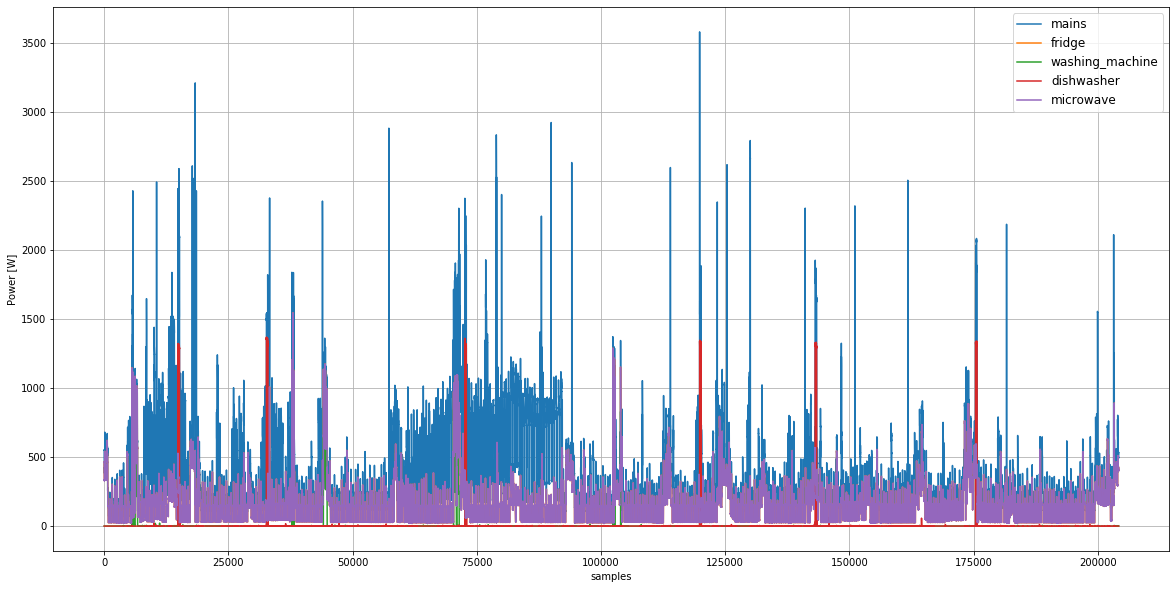

In [26]:
fig = plt.figure(num='Figure', figsize = [20,10])
ax1 = fig.add_subplot(111)

ax1.plot(df_align['aggregate'])
ax1.plot(df_align['fridge'])
ax1.plot(df_align['washingmachine'])
ax1.plot(df_align['dishwasher'])
ax1.plot(df_align['microwave'])


ax1.set_ylabel('Power [W]')
ax1.set_xlabel('samples')
ax1.legend(['mains', 'fridge', 'washing_machine', 'dishwasher', 'microwave'], fontsize = "large")
ax1.grid()

plt.show()